In [1]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
import aplpy
import matplotlib.patheffects as pe
from astropy.wcs import WCS
from matplotlib import cm

In [2]:
def v2ch(v, w): # convert velocity (km/s) to channel 
    x_tempo, y_tempo, v_tempo   = w.wcs_pix2world(0, 0, 0, 0)
    x_ch, y_ch, v_ch   = w.wcs_world2pix(x_tempo, y_tempo, v*1000.0, 0)
    v_ch = int(round(float(v_ch), 0))
    return v_ch

def ch2v(ch, w):#km/s
    x, y, v   = w.wcs_pix2world(0, 0, ch, 0)
    return v/1000.0

def del_header_key(header, keys): # delete header key
    import copy
    h = copy.deepcopy(header)
    for k in keys:
        try:
            del h[k]
        except:
            pass
    return h

def make_new_hdu_integ(hdu, v_start_wcs, v_end_wcs, w): # make hdu of integrated intensity map
    data = hdu.data
    header = hdu.header
    start_ch, end_ch = v2ch(v_start_wcs, w), v2ch(v_end_wcs, w)
    new_data = np.sum(data[start_ch:end_ch+1], axis=0)*np.abs(header["CDELT3"])/1000.0
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3", "PC1_3", "PC2_3", "PC3_3", "PC3_1", "PC3_2"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu

def make_new_hdu_integ_ch(hdu, v_start_ch, v_end_ch, w): # make hdu of integrated intensity map
    data = hdu.data
    header = hdu.header
    new_data = np.sum(data[v_start_ch:v_end_ch], axis=0)*header["CDELT3"]/1000.0
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3", "PC1_3", "PC2_3", "PC3_3", "PC3_1", "PC3_2"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu

In [3]:
import PIL.Image

def scale(data, scale_min=None, scale_max=None, stretch='linear'):
    if stretch == 'linear':
        scale_func = scale_linear
    elif stretch == 'log':
        scale_func = scale_log
    elif stretch == 'sqrt':
        scale_func = scale_sqrt
    else:
        scale_func = scale_linear
        pass

    if scale_min is None:
        scale_min = np.nanmin(data)
        pass

    if scale_max is None:
        scale_max = np.nanmax(data)
        pass

    scaled = scale_func(data, scale_min, scale_max)
    scaled = np.uint8(scaled * 255)
    return scaled

def scale_linear(data, scale_min, scale_max):
    print('%f, %f'%(scale_min, scale_max))
    scaled = (data - scale_min) / (scale_max - scale_min)
    scaled[np.where(scaled<0)] = 0
    scaled[np.where(scaled>=1)] = 1
    return scaled

def scale_log(data, scale_min, scale_max):
    print('%e, %e'%(scale_min, scale_max))
    scaled = scale_linear(data, scale_min, scale_max)
    scaled = np.log10((scaled * 9) + 1)
    return scaled

def scale_sqrt(self, data, scale_min, scale_max):
    print('%f, %f'%(scale_min, scale_max))
    scaled = scale_linear(data, scale_min, scale_max)
    scaled = np.sqrt(scaled)
    return scaled


In [8]:
def func_chmap_integ_nxm(rfits_name, gfits_name, bfits_name, v_start, ch_range, color_min_R, color_max_R, color_min_G, color_max_G, color_min_B, color_max_B, mapcenter_x, mapcenter_y, mapsize_x, mapsize_y, figsize, n, m, stretch_R, stretch_G, stretch_B):
    from astropy.io import fits
    from astropy.wcs import WCS
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import aplpy
    from matplotlib.colorbar import ColorbarBase
    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.colors import LogNorm
    import math
    import PIL.Image
    import os
    
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    save_name = f"pdf/ngc1333TP.{r_species}{g_species}{b_species}rgb.chmap_%.1f_kms_%ich_%ix%i"%(v_start, ch_range, n, m) #save name
    rhdu = fits.open(rfits_name)[0]
    ghdu = fits.open(gfits_name)[0]
    bhdu = fits.open(bfits_name)[0]
    
    pix_y = rhdu.shape[1]
    pix_x = rhdu.shape[2]
    
    
    rh = rhdu.header
    gh = ghdu.header
    bh = bhdu.header
    rd = rhdu.data
    gd = ghdu.data
    bd = bhdu.data
    rw = WCS(rh)
    gw = WCS(gh)
    bw = WCS(bh)
    ch_start_r = v2ch(v_start, rw)
    ch_start_g = v2ch(v_start, gw)
    ch_start_b = v2ch(v_start, bw)
    print(f"ch_s_r={ch_start_r}, ch_s_g={ch_start_g}, ch_s_b={ch_start_b}")
    position_addedlabel_x, position_addedlabel_y = mapcenter_x + mapsize_x*-0.05, mapcenter_y + mapsize_y*0.7 # label position, need to change

    fig = plt.figure(figsize=figsize)

    for i in range(n*m):
        ch_start_r_i, ch_end_r_i = int(ch_start_r+i*ch_range), int(ch_start_r+(i+1)*ch_range)
        ch_start_g_i, ch_end_g_i = int(ch_start_g+i*ch_range), int(ch_start_g+(i+1)*ch_range)
        ch_start_b_i, ch_end_b_i = int(ch_start_b+i*ch_range), int(ch_start_b+(i+1)*ch_range)
        v_start_r, v_end_r = ch2v(ch_start_r_i, rw), ch2v(ch_end_r_i-1, rw)
        v_start_g, v_end_g = ch2v(ch_start_g_i, gw), ch2v(ch_end_g_i-1, gw)
        v_start_b, v_end_b = ch2v(ch_start_b_i, bw), ch2v(ch_end_b_i-1, bw)
        rhdu_color = make_new_hdu_integ_ch(rhdu, ch_start_r_i, ch_end_r_i , rw)
        ghdu_color = make_new_hdu_integ_ch(ghdu, ch_start_g_i, ch_end_g_i , gw)
        bhdu_color = make_new_hdu_integ_ch(bhdu, ch_start_b_i, ch_end_b_i , bw)
        img = np.zeros([pix_y, pix_x, 3], dtype=np.uint8)
        img[:,:,0] = scale(rhdu_color.data[::-1,:], color_min_R, color_max_R, stretch_R)
        img[:,:,1] = scale(ghdu_color.data[::-1,:], color_min_G, color_max_G, stretch_G)
        img[:,:,2] = scale(bhdu_color.data[::-1,:], color_min_B, color_max_B, stretch_B)
        save_panel = f'pdf/ngc1333TP.{r_species}{g_species}{b_species}rgb.chmap_panel%ix%i'%(n,m)
        PIL.Image.fromarray(img).save(save_panel + '.png')

        panelimg = PIL.Image.open(save_panel + '.png')
        f = aplpy.FITSFigure(rhdu_color, slices=[0], figure=fig, subplot=[0.1+(0.8/float(n)*math.floor(i%n)),0.9-(0.8/float(m)*math.floor(i/n+1)), 0.8/float(n), 0.8/float(m)], convention='wells')
        f.recenter(mapcenter_x, mapcenter_y, width=mapsize_x, height=mapsize_y)
        f.show_rgb(save_panel + '.png')
        f.frame.set_color('w')
        f.ticks.set_color('w')
        f.ticks.set_tick_direction('in')
        v_start_label, v_end_label = ch2v(ch_start_r_i, rw), ch2v(ch_end_r_i, rw)
        f.add_label(position_addedlabel_x, position_addedlabel_y, "%.1f - %.1f km s$^{-1}$"%(v_start_label, v_end_label), color="white",path_effects = [pe.withStroke(linewidth=3,foreground = 'k')], size=14, family='serif', weight='bold') #velocity label
        f.show_markers(285.4231667, -36.9753333, c='w', marker='+', s=100, linewidths=2, zorder=4) #IRS2
        if int(i/n) != (m-1):
            f.tick_labels.hide_x()
            f.axis_labels.hide_x()
        if int(i%n) != 0:
            f.tick_labels.hide_y()
            f.axis_labels.hide_y()
        if i == 0 :
            line1_label_x, line1_label_y = mapcenter_x + mapsize_x*0.3, mapcenter_y - mapsize_y*0.45
            line2_label_x, line2_label_y = mapcenter_x + mapsize_x*0.3, mapcenter_y - mapsize_y*0.55
            line3_label_x, line3_label_y = mapcenter_x + mapsize_x*0.3, mapcenter_y - mapsize_y*0.65
            f.add_label(line1_label_x, line1_label_y, r_species, color='r', size=14, family='serif', weight='bold') #line1 label
            f.add_label(line2_label_x, line2_label_y, g_species, color='g', size=14, family='serif', weight='bold') #line2 label
            f.add_label(line3_label_x, line3_label_y, b_species, color='b', size=14, family='serif', weight='bold') #line3 label
        print(i+1, "/", n*m)
        print(f"ch_s={ch_start_r_i}, ch_e={ch_end_r_i}")

    f.save(save_name+'.pdf', dpi=150)
    #os.system('rm -rf ../pdf/cra12m.12CO13COC18Orgb.chmap_panel*.png')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


ch_s_r=263, ch_s_g=263, ch_s_b=108
0.000000, 2.500000


C:\Users\alexf\AppData\Local\Temp\ipykernel_19256\3815124872.py:23: RuntimeWarning: invalid value encountered in cast
  scaled = np.uint8(scaled * 255)


0.000000, 0.600000
0.000000, 0.150000
1 / 9
ch_s=263, ch_e=265
0.000000, 2.500000
0.000000, 0.600000
0.000000, 0.150000


C:\Users\alexf\AppData\Local\Temp\ipykernel_19256\3815124872.py:23: RuntimeWarning: invalid value encountered in cast
  scaled = np.uint8(scaled * 255)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=265, ch_e=267
0.000000, 2.500000
0.000000, 0.600000
0.000000, 0.150000


C:\Users\alexf\AppData\Local\Temp\ipykernel_19256\3815124872.py:23: RuntimeWarning: invalid value encountered in cast
  scaled = np.uint8(scaled * 255)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=267, ch_e=269
0.000000, 2.500000
0.000000, 0.600000
0.000000, 0.150000


C:\Users\alexf\AppData\Local\Temp\ipykernel_19256\3815124872.py:23: RuntimeWarning: invalid value encountered in cast
  scaled = np.uint8(scaled * 255)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=269, ch_e=271
0.000000, 2.500000
0.000000, 0.600000
0.000000, 0.150000


C:\Users\alexf\AppData\Local\Temp\ipykernel_19256\3815124872.py:23: RuntimeWarning: invalid value encountered in cast
  scaled = np.uint8(scaled * 255)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=271, ch_e=273
0.000000, 2.500000
0.000000, 0.600000
0.000000, 0.150000


C:\Users\alexf\AppData\Local\Temp\ipykernel_19256\3815124872.py:23: RuntimeWarning: invalid value encountered in cast
  scaled = np.uint8(scaled * 255)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=273, ch_e=275
0.000000, 2.500000
0.000000, 0.600000
0.000000, 0.150000


C:\Users\alexf\AppData\Local\Temp\ipykernel_19256\3815124872.py:23: RuntimeWarning: invalid value encountered in cast
  scaled = np.uint8(scaled * 255)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=275, ch_e=277
0.000000, 2.500000
0.000000, 0.600000
0.000000, 0.150000


C:\Users\alexf\AppData\Local\Temp\ipykernel_19256\3815124872.py:23: RuntimeWarning: invalid value encountered in cast
  scaled = np.uint8(scaled * 255)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=277, ch_e=279
0.000000, 2.500000


C:\Users\alexf\AppData\Local\Temp\ipykernel_19256\3815124872.py:23: RuntimeWarning: invalid value encountered in cast
  scaled = np.uint8(scaled * 255)


0.000000, 0.600000
0.000000, 0.150000


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=279, ch_e=281


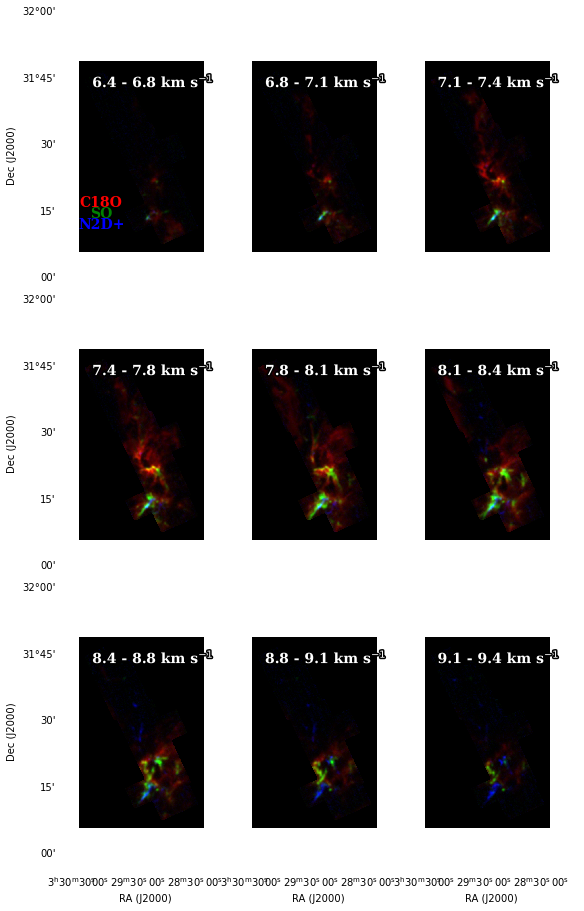

In [14]:
rfits_name='C:\\Users\\alexf\Japan internship\\C18O\\ngc1333TP.C18O.cube.valueK.fits'
r_species = 'C18O'
gfits_name ='C:\\Users\\alexf\Japan internship\\SO\\ngc1333TP.SO.cube.valueK.fits'
g_species = 'SO'
bfits_name ='C:\\Users\\alexf\Japan internship\\N2D\\ngc1333TP.N2D.cube.valueK.fits'
b_species = 'N2D+'
mapcenter_x, mapcenter_y, mapsize_x, mapsize_y = 52.3018836, 31.4612649, 0.65, 0.4 # identify map center position and mapsize in degree
v_start = 6.4 # identify start velocity pisition (km/s)
ch_range = 2 # number of channels in 1 panel
color_min_R = 0.0 # color range
color_max_R = 2.5
color_min_G = 0.0
color_max_G = 0.6
color_min_B = 0.0
color_max_B = 0.15
n, m = 3, 3 # number of columns, number of rows
figsize = (n*3, m*5) # figure size
stretch_R = "linear" # color scale    linear or log or sqrt
stretch_G = "linear" # linear or log or sqrt
stretch_B = "linear" # linear or log or sqrt
func_chmap_integ_nxm(rfits_name, gfits_name, bfits_name, v_start, ch_range, color_min_R, color_max_R, color_min_G, color_max_G, color_min_B, color_max_B, mapcenter_x, mapcenter_y, mapsize_x, mapsize_y, figsize, n, m, stretch_R, stretch_G, stretch_B)